# Image Processing for SEM generated unspun carbon fiber images : Part 2

We take SEM images of carbon fibers and apply K-means clustering to segregate fiber regions from non-fiber regions. 

## TK Means clustering: core idea

Here, we are varying the stride length of the sliding window between two tiles. In Template matching this stride length was 1 pixel. 
Main idea of Kmeans: divide the pixels into clusters by partitioning the pixel intensity plot using Voronoi polyhedra 

1. select an area that looks like our target object --> that is the 'template'
2. flatten the template and vectorize it
3. plot it on the intensity plot 
4. Initialize centroids in the intensity plot 
5. construct voronoi polyhedra (polyhedron consisting of all the points closest to the corresponding centroid) around each centroids (number of centroids is the "K") 
6. calculate new centroids by averaging all points within a centroid's Voronoi polyhedron
7. Repeat previous two steps until polyhedra are optimally selected (positions of the centroids do not change significantly if the last two steps are repeated further)  
8. For each cluster assign a label: target object or not target object

### Model parameters:
Number of clusters<br>
Tile size<br>
Stride length

## Why K-means?

### Advantages:
1. No need to select template or threshold
2. Fast, memory efficient 

### Drawbacks: 
1. Need to select number of clusters (centroids)
2. Can suffer from concave shaped blobs

In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from skimage import util
from sklearn.cluster import KMeans, MiniBatchKMeans

## Importing the image

This time we use numpy to read the image as an n-dimensional array and display its resolution

resolution of the image :  (619, 619)


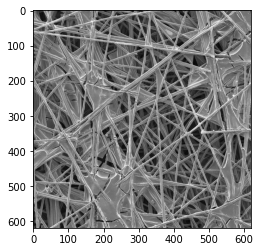

In [20]:
img_in = np.array(Image.open('SEM_carbonfiber.png').convert('L'))
print("resolution of the image : ", img_in.shape)
img_plot = plt.imshow(img_in, cmap='gray')

## <u>Define the parameters<u>

In [5]:
wsize = 30 #define the window size in pixels. This is the side length of each tile<br>
n_clusters = 5 #defines the number of clusters <br>
stride = 3 #defines the stride length. This is the number of pixels shifted between two tiles
seed = 186588 #defines a randome seed used to determine the starting position of the centroids. 

## <u>Preprocess the image<u>

In [8]:
#define a function to add some padding to the image so that we can have integer number of tiles

def pad(img, wsize, stride=1):
    """adds a few pixels to the image as padding to have integer number of tiles 
    Args: 
        img (np.array of shape(img.shape)): Array containing the image
        wsize (int): side length of tile 
        stride (int): number of pixels between two tiles
    
    Returns: 
        img(np.array): Padded image ie image with a few additional pixels
    """
    # Such a string with triple quotes if used after defining a function gets associated with it and can be 
    #accessed using the command help(function)
    
    height, width = img.shape
    if stride == 'block':
        adj = 0
        stride = wsize 
    else: 
        adj = 1
    
    px = wsize - height % stride - adj
    if px%2 ==0:
        px = int(px/2)
        px = (px,px)
    else: 
        px = int((px-1)/2)
        px = (px, px+1) 
        
    py = wsize - width % stride - adj
    if py%2 == 0:       
        py = int(py/2)
        py = (py,py)
    else: 
        py = int((py-1)/2)
        py = (py, py+1)
        
    return np.pad(img, pad_width=(px,py), mode = 'symmetric')

In [9]:
#define a variable X which is a numpy array with each element a tile

X = util.view_as_windows(
    pad(img_in, wsize=wsize, stride=stride), #add padding to original image
    window_shape = (wsize, wsize),           #define the tile size
    step=stride)                             #define the stride length

mask_dim = X.shape[:2] #pick the first two values in the shape which correspond to the number of tiles
                       #This can be called the reduced image where each pixel represents one tile

X=X.reshape(-1, wsize**2) # reshape "X" to get an array of the tiles as vectors. The resulting array hass 
                          # the dimensions "number of tiles x number of pixels per tile"

## <u>Run the model<u>

In [11]:
kmeans = KMeans(
    n_clusters = n_clusters,
    random_state = seed) #create a Kmeans object containing this method

%time kmeans = kmeans.fit(X) #fit the model to our pre-processed data 

CPU times: user 2min 4s, sys: 5.96 s, total: 2min 10s
Wall time: 40.5 s


In [12]:
#for minibatch means, instead of taking all the points in a Voronoi polyhdedron to calculate new centroid,
#use subset of points selected randomly
mb_kmeans = MiniBatchKMeans(
    n_clusters = n_clusters,
    random_state = seed)

%time mb_kmeans = mb_kmeans.fit(X)

CPU times: user 1.02 s, sys: 985 ms, total: 2.01 s
Wall time: 1.22 s


## <u>Post-process the fitted data<u>

In [15]:
mask = kmeans.labels_.reshape(*mask_dim) #reshape the "labels" attribute to match the dimensions of reduced image
mask = Image.fromarray(mask) #convert the mask into an Image object

mb_mask = mb_kmeans.labels_.reshape(*mask_dim) 
mb_mask = Image.fromarray(mb_mask) 

In [16]:
clusters = np.array(mask.resize(img_in.shape[::-1]))+1 #scale the reduced image to size of input image 
mb_clusters = np.array(mb_mask.resize(img_in.shape[::-1]))+1

## <u> Plot the segmented images<u>

Text(0.5, 1.0, 'Original')

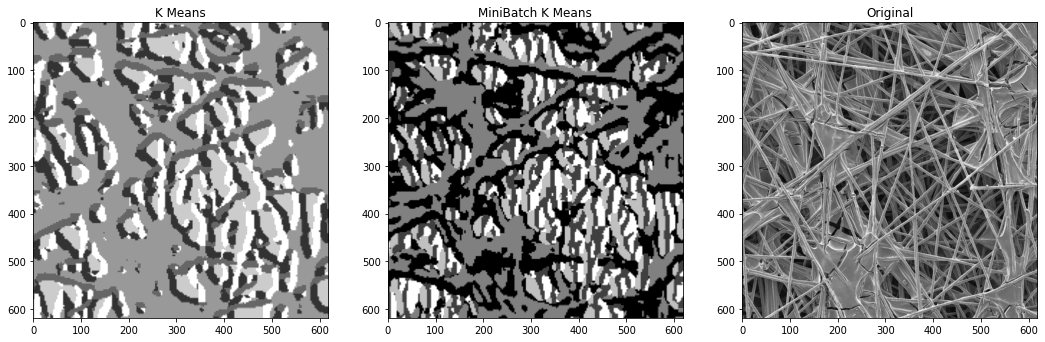

In [22]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18,6))

ax[0].imshow(clusters, cmap='gray')
ax[1].imshow(mb_clusters, cmap='gray')
ax[2].imshow(img_in, cmap='gray')

ax[0].set_title('K Means')
ax[1].set_title('MiniBatch K Means')
ax[2].set_title('Original')

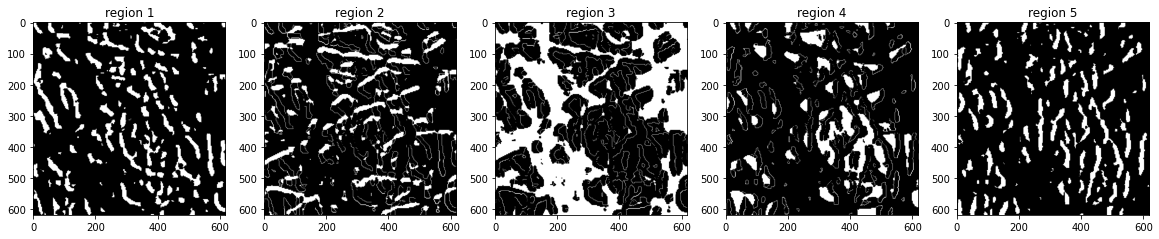

In [23]:
#create a figure where each of the regions are plotted separately 

fig, ax = plt.subplots(nrows=1, ncols=n_clusters, figsize=(4*n_clusters,4))

for ncl in range(1, n_clusters+1):
    ax[ncl-1].imshow(np.where(clusters == ncl, 1, 0), cmap='gray')
    ax[ncl-1].set_title("region %i" %ncl)

## Varying the parameters

In [ ]:
#define a function that does 